# Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast

from tqdm.auto import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Loading Data 

In [2]:
# Load the CSV files
train_df = pd.read_csv('dataset/csvs/train_df.csv')
test_df = pd.read_csv('dataset/csvs/test_df.csv')
val_df = pd.read_csv('dataset/csvs/val_df.csv')

In [3]:
train_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,3231,58,Female,3231_left.jpg,3231_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3231_left.jpg
1,3960,55,Male,3960_left.jpg,3960_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",3960_left.jpg
2,1657,50,Female,1657_left.jpg,1657_right.jpg,lens dust，pathological myopia,mild nonproliferative retinopathy,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",1657_right.jpg
3,277,75,Male,277_left.jpg,277_right.jpg,normal fundus,drusen,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",277_left.jpg
4,364,45,Male,364_left.jpg,364_right.jpg,myelinated nerve fibers,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",364_left.jpg


# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

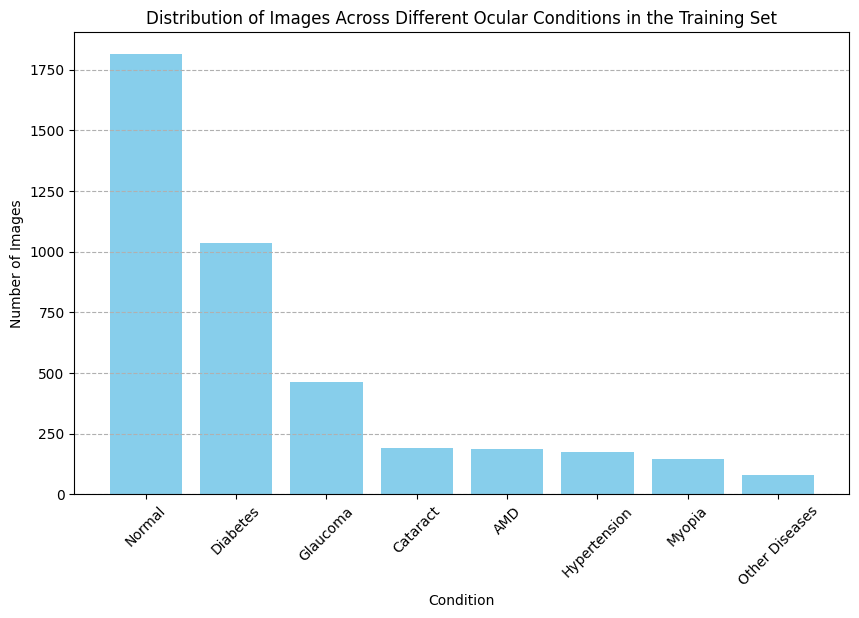

{'Normal': 1814,
 'Diabetes': 1035,
 'Glaucoma': 463,
 'Cataract': 190,
 'AMD': 188,
 'Hypertension': 174,
 'Myopia': 147,
 'Other Diseases': 79}

In [4]:
# Sum up the occurrences of each condition
# Sum up all the target lists to get the class distribution
class_distribution = train_df['target'].value_counts()

# Assuming class_labels are in the correct order as per your earlier description
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values(), color='skyblue')
plt.title('Distribution of Images Across Different Ocular Conditions in the Training Set')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

# Also, return the class distribution for detailed examination
class_distribution_dict

# Undersampling the Majority Classes
- Diabetes and Normal to 1000 images 

In [5]:
import pandas as pd
from sklearn.utils import resample

def undersample_majority_class(df, majority_index=0, desired_samples=500):
    """
    This function undersamples the majority class in the dataframe where the 'target' column is a list.
    df: Your dataframe.
    majority_index: The index in the 'target' list that corresponds to the majority class.
    desired_samples: The number of samples to undersample to.
    """
    # Convert the 'target' string representation of a list to an actual list
    df['target_list'] = df['target'].apply(ast.literal_eval)
    
    # Filter the majority class
    majority_class_df = df[df['target_list'].apply(lambda x: x[majority_index] == 1)]
    
    # Check if the desired number of samples is greater than the number of samples in the majority class
    if desired_samples > len(majority_class_df):
        desired_samples = len(majority_class_df)  # Set desired_samples to the number of samples in the majority class
    
    # Undersample the majority class to the desired number of samples
    majority_class_undersampled = resample(majority_class_df,
                                           replace=False,  # sample without replacement
                                           n_samples=desired_samples,  # to match minority class
                                           random_state=123)  # for reproducible results
    
    # Remove the original majority class samples from the dataframe
    df = df[df['target_list'].apply(lambda x: x[majority_index] == 0)]
    
    # Concatenate the undersampled dataframe with the remaining data
    df = pd.concat([df, majority_class_undersampled], axis=0)
    
    # Clean up: Remove the 'target_list' column if no longer needed
    df.drop('target_list', axis=1, inplace=True)
    
    return df

# Usage example:
# Assuming 'target' at index 0 represents the 'Normal' class and we want to undersample to 1000 samples
new_df = undersample_majority_class(train_df, majority_index=0, desired_samples=1000)
new_df = undersample_majority_class(new_df, majority_index=1, desired_samples=1000)


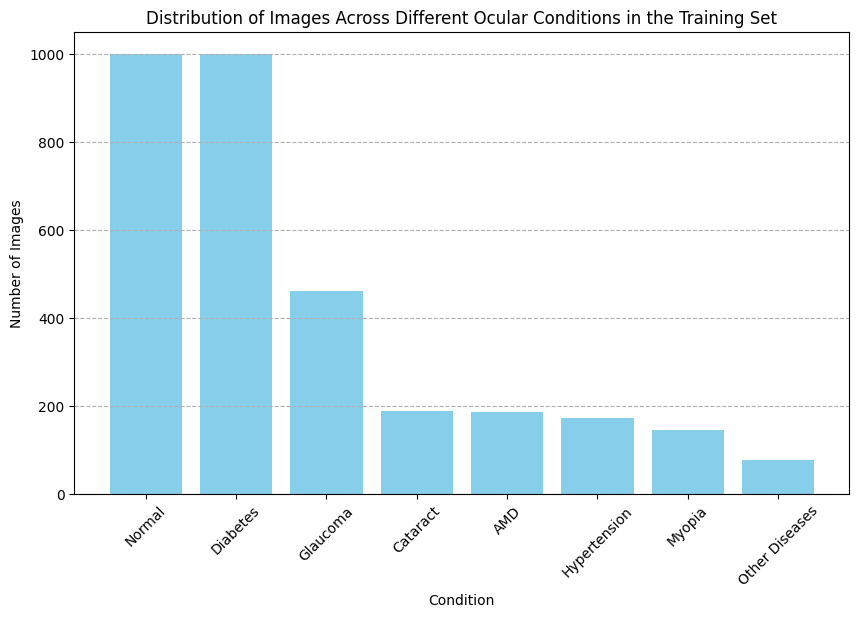

{'Normal': 1000,
 'Diabetes': 1000,
 'Glaucoma': 463,
 'Cataract': 190,
 'AMD': 188,
 'Hypertension': 174,
 'Myopia': 147,
 'Other Diseases': 79}

In [6]:
# Sum up the occurrences of each condition
# Sum up all the target lists to get the class distribution
class_distribution = new_df['target'].value_counts()

# Assuming class_labels are in the correct order as per your earlier description
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values(), color='skyblue')
plt.title('Distribution of Images Across Different Ocular Conditions in the Training Set')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

# Also, return the class distribution for detailed examination
class_distribution_dict

# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [7]:
# Assuming 'class_distribution' is a dictionary with your class labels and counts
target_sample_count = max(class_distribution_dict.values())  # or set a custom target

augmentations_needed = {
    class_label: target_sample_count - count 
    for class_label, count in class_distribution_dict.items() if count < target_sample_count
}

# Calculate the number of augmentations needed per existing sample
augmentations_per_sample = {
    class_label: (augmentations_needed[class_label] // count) + 1  # Adding 1 for at least one augmentation
    for class_label, count in class_distribution_dict.items() if class_label in augmentations_needed
}

print(augmentations_per_sample)

{'Glaucoma': 2, 'Cataract': 5, 'AMD': 5, 'Hypertension': 5, 'Myopia': 6, 'Other Diseases': 12}


In [9]:
# Initialize the ImageDataGenerator with suitable augmentations for fundus images
augmentation = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.05,
    vertical_flip=True,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.2, 1.0],
    shear_range=0.05,
    fill_mode="constant",
)

save_directory = 'dataset/train_augmented_images/'
os.makedirs(save_directory, exist_ok=True)

augmentations_needed = {   # Doubling augementations needed for all classes
    0: 0,   # Normal
    1 : 0,  # Diabetes 
    2 :2,
    3 : 5, # Cataract
    4 : 5, # AMD
    5 : 5, # Hypertension
    6 : 6, # Myopia
    7 : 12   # Other Diseases + 1
}

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    # Original image path
    img_path = os.path.join('dataset/ODIR-5k/Training Images', row['filename'])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_rows = []
    
    # Determine the maximum number of augmentations needed
    targets = ast.literal_eval(row['target'])
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])
    
    # Save the original image to the new directory with a prefix to indicate it's original
    original_filename = f"original_{row['filename']}"
    original_save_path = os.path.join(save_directory, original_filename)
    img.save(original_save_path)  # Save the original image
    
    # Update the row for the original image and add to the augmented rows list
    original_row = row.copy()
    original_row['filename'] = original_filename
    augmented_rows.append(original_row)
    
    if max_augmentations_needed > 0:
        # Generate and save augmented images
        for i in range(max_augmentations_needed):
            # Manual save for more control over filenames
            augmented_img = next(augmentation.flow(x, batch_size=1))[0]  # Get one sample
            augmented_img = Image.fromarray(np.uint8(augmented_img))  # Convert to PIL Image to save
            unique_filename = f'aug_{i}_{row["filename"]}'
            save_path = os.path.join(save_directory, unique_filename)
            augmented_img.save(save_path)  # Save the augmented image
            
            # Update row for augmented image and add to the list
            augmented_row = row.copy()
            augmented_row['filename'] = unique_filename
            augmented_rows.append(augmented_row)
    
    return augmented_rows

# Usage with ThreadPoolExecutor, assuming df_train_final is your DataFrame to process
augmented_data = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = []
    for _, row in new_df.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            augmented_rows = future.result()
            augmented_data.extend(augmented_rows)  # Extend the list with both original and augmented rows
        except Exception as e:
            print(f"Error processing image: {e}")

# Assuming df_train_final and the necessary libraries are correctly defined
df_augmented = pd.DataFrame(augmented_data)
df_augmented.to_csv('dataset/augmented_train.csv', index=False)

Augmenting Images:   0%|          | 0/3241 [00:00<?, ?it/s]

# Creating Datasets 

In [12]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

In [13]:
def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


In [14]:
def load_and_prepare_aug_dataset(df, images_dir, shuffle=True, batch_size=32):
    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images = images_dir + df['filename']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels = df['target'].values

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset

In [15]:
train_ds = load_and_prepare_aug_dataset(df_augmented, 'dataset/Augmented Images/', shuffle=True, batch_size=32)
val_ds = load_and_prepare_dataset(val_df, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=32)
test_ds = load_and_prepare_dataset(test_df, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=32)

In [16]:
print("size of training dataset: ", train_ds.cardinality().numpy())
print("size of validation dataset: ", val_ds.cardinality().numpy())
print("size of test dataset: ", test_ds.cardinality().numpy())

size of training dataset:  608
size of validation dataset:  64
size of test dataset:  80


# Loading and Visualising the Training Data 

In [17]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")

Training dataset


NotFoundError: NewRandomAccessFile failed to Create/Open: dataset/Augmented Images/original_1657_right.jpg : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

Validation dataset
(32, 224, 224, 3)
(32, 8)


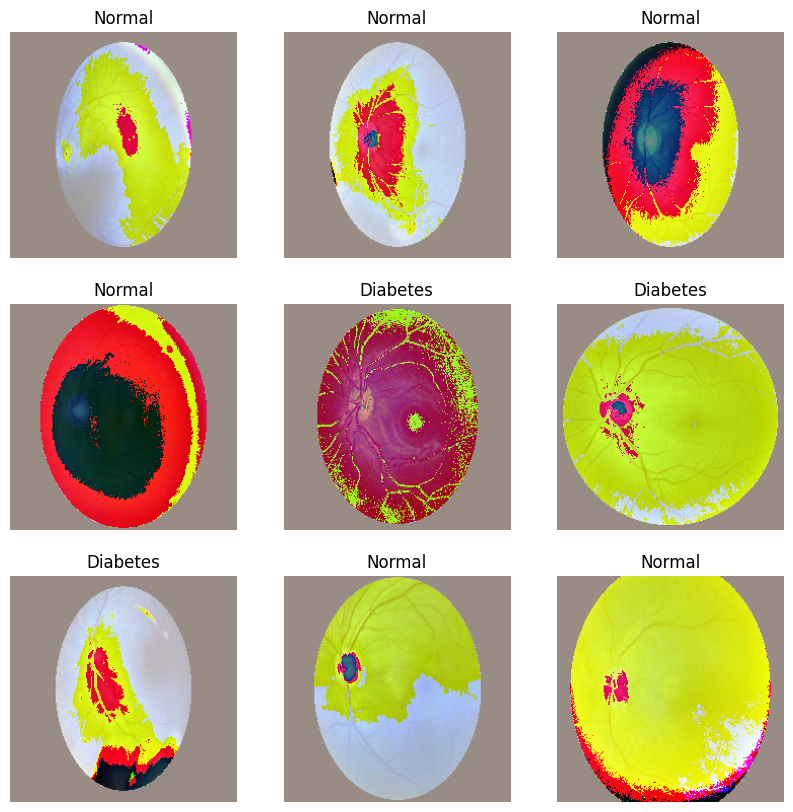

In [ ]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

In [ ]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model_Resnet50_AUG.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1) # increased patience from 3 to 5 and factor from 0.2 to 0.5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # increased from 5 to 10


callbacks = [early_stopping, checkpoint, reduce_lr]

In [ ]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

In [ ]:
resnet_50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs =  50
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/50
608/608 [==============================] - ETA: 0s - loss: 0.9573 - accuracy: 0.6757
Epoch 1: val_loss improved from inf to 1.53803, saving model to best_model_Resnet50_AUG.h5
608/608 [==============================] - 160s 130ms/step - loss: 0.9573 - accuracy: 0.6757 - val_loss: 1.5380 - val_accuracy: 0.3416 - lr: 1.0000e-04
Epoch 2/50
607/608 [============================>.] - ETA: 0s - loss: 0.7198 - accuracy: 0.7495
Epoch 2: val_loss improved from 1.53803 to 1.34966, saving model to best_model_Resnet50_AUG.h5
608/608 [==============================] - 160s 133ms/step - loss: 0.7198 - accuracy: 0.7495 - val_loss: 1.3497 - val_accuracy: 0.4511 - lr: 1.0000e-04
Epoch 3/50
607/608 [============================>.] - ETA: 0s - loss: 0.6342 - accuracy: 0.7757
Epoch 3: val_loss did not improve from 1.34966
608/608 [==============================] - 150s 130ms/step - loss: 0.6341 - accuracy: 0.7758 - val_loss: 1.3918 - val_accuracy: 0.4814 - lr: 1.0000e-04
Epoch 4/50
607/608 [===

# Evaluating Model 

Model Accuracy Graph Analysis

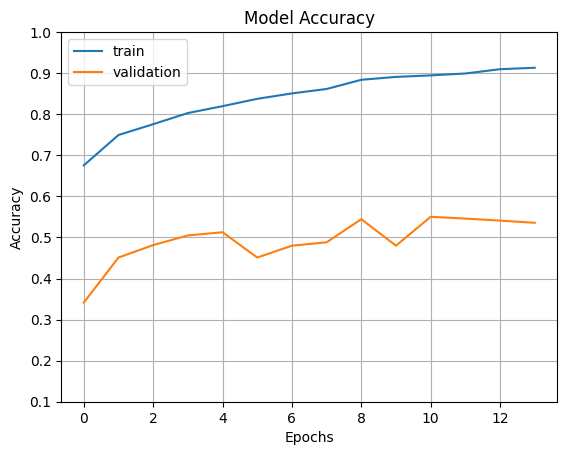

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

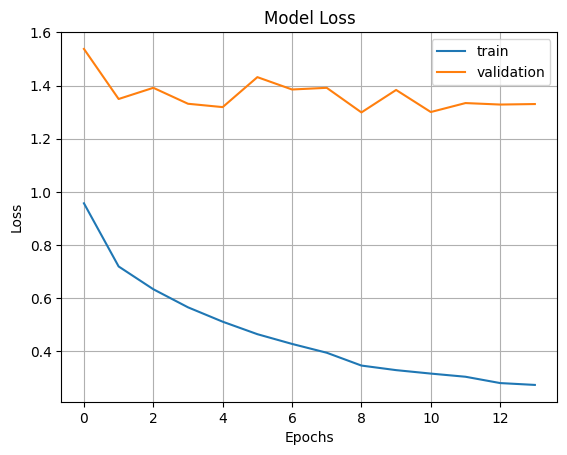

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
resnet_50_model = load_model('best_model_Resnet50.h5')

# Evaluate the model on the test dataset
evaluation_results = resnet_50_model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = resnet_50_model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Predictions Result Evaluation

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [ ]:
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


Balanced Accuracy Score 

In [ ]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [ ]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

Confusion Matrix 

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

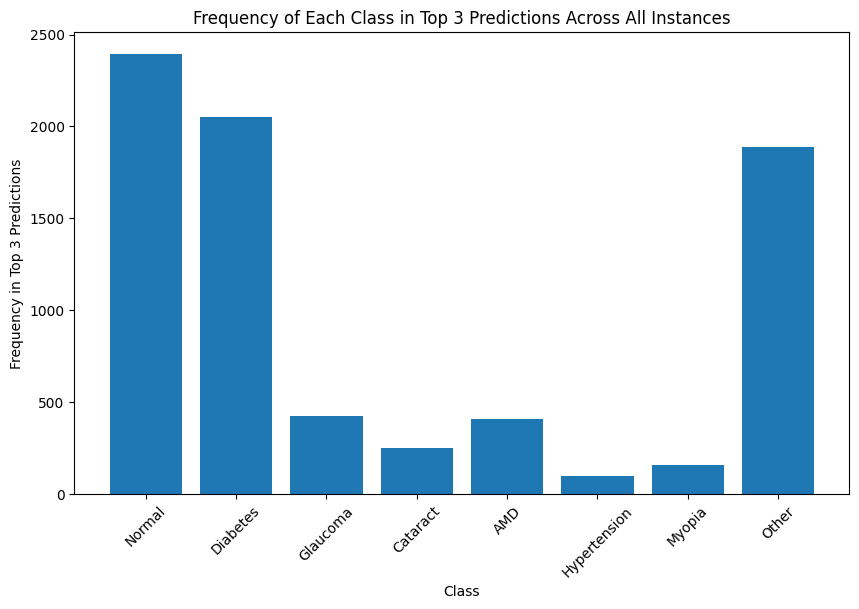

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()